# Loading Data

In [89]:
import pandas as pd

# Read the CSVs
footbridge = pd.read_csv('Creek Data/footbridge.csv')

grinnel=pd.read_csv('Creek Data/grinnel.csv')



# General Statisics 

In [90]:
footbridge.describe()

[SCNF010 Equipment ] EnviroDIY_Mayfly_Temp (degC)  \
count                                       82789.000000   
mean                                           59.637736   
std                                            61.280213   
min                                         -9999.000000   
25%                                            19.500000   
50%                                            84.000000   
75%                                            94.000000   
max                                           100.000000   

       [SCNF010 Liquid aqueous : 0.3 m] Meter_Hydros21_Depth (mm)  \
count                                      244495.000000            
mean                                         -121.465097            
std                                           645.124352            
min                                         -9999.000000            
25%                                          -141.500000            
50%                                            86.200000            
75%                                           123.200000            
max                                          1265.300000            

       [SCNF010 Liquid aqueous : 0 m] Meter_Hydros21_Cond (uS/cm)  \
count                                      244496.000000            
mean                                          332.404187            
std                                           480.329496            
min                                         -9999.000000            
25%                                           274.200000            
50%                                           342.200000            
75%                                           437.700000            
max                                           947.700000            

       [SCNF010 Equipment ] Digi_Cellular_SignalPercent (%)  \
count                                      198815.000000      
mean                                           52.722531      
std                                           654.396665      
min                                         -9999.000000      
25%                                            90.000000      
50%                                            97.000000      
75%                                           100.000000      
max                                           109.000000      

       [SCNF010 Liquid aqueous : 0.3 m] Meter_Hydros21_Temp (degC)  \
count                                      244494.000000             
mean                                            1.703505             
std                                           450.460951             
min                                         -9999.000000             
25%                                            19.400000             
50%                                            21.700000             
75%                                            24.600000             
max                                            36.200000             

       [SCNF010 Equipment ] EnviroDIY_Mayfly_Batt (V)  
count                                   246551.000000  
mean                                         4.203895  
std                                          0.159912  
min                                          3.548000  
25%                                          4.139000  
50%                                          4.169000  
75%                                          4.382000  
max                                          5.034000

In [91]:
grinnel.describe()

[SCSF050 Liquid aqueous ] Meter_Hydros21_Cond (uS/cm)  \
count                                      140465.000000       
mean                                         -135.847860       
std                                          2117.712104       
min                                         -9999.000000       
25%                                           230.700000       
50%                                           299.500000       
75%                                           409.200000       
max                                           605.300000       

       [SCSF050 Equipment ] Digi_Cellular_SignalPercent (%)  \
count                                      140466.000000      
mean                                          100.510259      
std                                            15.392111      
min                                             0.000000      
25%                                            90.000000      
50%                                           109.000000      
75%                                           109.000000      
max                                           109.000000      

       [SCSF050 Liquid aqueous ] Meter_Hydros21_Temp (degC)  \
count                                      140468.000000      
mean                                         -356.298330      
std                                          1903.799972      
min                                         -9999.000000      
25%                                            15.700000      
50%                                            20.020000      
75%                                            22.700000      
max                                            31.200000      

       [SCSF050 Liquid aqueous ] Meter_Hydros21_Depth (mm)  \
count                                      140469.000000     
mean                                         -129.522665     
std                                          2119.182549     
min                                         -9999.000000     
25%                                           322.300000     
50%                                           341.000000     
75%                                           372.300000     
max                                          1434.800000     

       [SCSF050 Equipment ] EnviroDIY_Mayfly_Batt (V)  \
count                                   140469.000000   
mean                                       -59.926619   
std                                        797.684861   
min                                      -9999.000000   
25%                                          4.094000   
50%                                          4.109000   
75%                                          4.124000   
max                                         27.000000   

       [SCSF050 Equipment ] EnviroDIY_Mayfly_Temp (degC)  
count                                      140467.000000  
mean                                           18.664234  
std                                             9.045014  
min                                             0.500000  
25%                                            12.000000  
50%                                            16.750000  
75%                                            24.250000  
max                                            47.500000

# Serpate Data by year

In [92]:

footbridge['Monitoring Date (local time of sensor)'] = pd.to_datetime(footbridge['Monitoring Date (local time of sensor)'])
footbridge['year']=footbridge['Monitoring Date (local time of sensor)'].dt.year
footbridge_by_year = {year: data for year, data in footbridge.groupby('year')}

In [93]:
grinnel['Monitoring Date (local time of sensor)'] = pd.to_datetime(grinnel['Monitoring Date (local time of sensor)'])
grinnel['year']=grinnel['Monitoring Date (local time of sensor)'].dt.year
grinnel_by_year = {year: data for year, data in grinnel.groupby('year')}

# add rain data from open metro

In [94]:
import pandas as pd
import numpy as np
import requests
import re

# ===================================================================
#  1. HELPER FUNCTION DEFINITIONS
# ===================================================================

def clean_column_names(df):
    """
    Cleans, standardizes, and consolidates messy sensor column names in a DataFrame.
    This version correctly handles and merges duplicate columns (e.g., two temp sensors).
    """
    rename_map = {}
    name_patterns = {
        'datetime': 'Monitoring Date', 'temperature': 'Temp', 'depth': 'Depth',
        'conductivity': 'Cond', 'battery': 'Batt', 'signal_percent': 'SignalPercent'
    }

    # First, create a map of old names to new, simple names
    for old_name in df.columns:
        for new_name, pattern in name_patterns.items():
            if pattern in old_name:
                rename_map[old_name] = new_name
                break
    
    # Rename the columns. This step may create duplicate column names.
    df.rename(columns=rename_map, inplace=True)

    # Now, find and consolidate the duplicates
    unique_renamed_cols = set(rename_map.values())
    for name in unique_renamed_cols:
        # Check if any column name was created more than once
        if df.columns.tolist().count(name) > 1:
            # Select all columns with the same duplicate name
            dup_cols_df = df.loc[:, df.columns == name]
            
            # Consolidate them into a single series
            consolidated_series = dup_cols_df.bfill(axis=1).iloc[:, 0]
            
            # Drop all columns with the duplicate name from the original dataframe
            df.drop(columns=[name], inplace=True)
            
            # Add the single, consolidated series back
            df[name] = consolidated_series

def get_openmeteo_rain(lat, lon, start, end):
    """Fetches hourly precipitation for a given location and date range."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat, "longitude": lon, "start_date": start, "end_date": end,
        "hourly": "precipitation", "timezone": "auto"
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    df = pd.DataFrame({
        "datetime": pd.to_datetime(data["hourly"]["time"]),
        "rain_mm": data["hourly"]["precipitation"]
    })
    return df

# ===================================================================
#  2. MAIN PROCESSING FUNCTION
# ===================================================================

def create_final_dataset(file_path_map, lat=37.87, lon=-122.27):
    """
    Loads, cleans, combines, and merges sensor data with rain data.
    """
    all_sensors_list = []
    print("Loading and cleaning sensor data files...")
    for name, path in file_path_map.items():
        # Load the data
        df = pd.read_csv(path)
        # Clean the column names
        clean_column_names(df)
        # Add the location identifier
        df['location'] = name
        all_sensors_list.append(df)
    
    # --- Combine and consolidate the cleaned sensor data ---
    all_data = pd.concat(all_sensors_list, ignore_index=True)
    all_data['datetime'] = pd.to_datetime(all_data['datetime'], errors='coerce')
    all_data.dropna(subset=['datetime'], inplace=True)
    all_data.replace(-9999.0, np.nan, inplace=True)
    
    # --- Fetch rain data for the entire date range of the sensor data ---
    min_year = all_data['datetime'].min().year
    max_year = all_data['datetime'].max().year
    today = pd.Timestamp.now().date()
    
    print(f"Fetching rain data from {min_year} to {max_year}... 🌦️")
    all_rain_list = []
    for year in range(min_year, max_year + 1):
        start_date, end_date = f"{year}-01-01", f"{year}-12-31"
        if year == today.year:
            end_date = today.strftime('%Y-%m-%d')
        rain_year_df = get_openmeteo_rain(lat, lon, start_date, end_date)
        all_rain_list.append(rain_year_df)
    rain_df = pd.concat(all_rain_list, ignore_index=True)
    
    # --- Merge sensor data with the nearest rain measurement ---
    print("Merging rain data... 🔗")
    all_data = all_data.sort_values('datetime')
    rain_df = rain_df.sort_values('datetime')
    final_df = pd.merge_asof(all_data, rain_df, on='datetime', direction='nearest')
    
    print("Process complete!")
    return final_df

# ===================================================================
#  3. RUN THE WORKFLOW
# ===================================================================

# --- Step 1: Define the paths to your data files ---
# !!! EDIT THIS DICTIONARY WITH YOUR FILE PATHS !!!
file_paths = {
    'grinnel': 'Creek Data/grinnel.csv',
    'footbridge': 'Creek Data/footbridge.csv'
}

# --- Step 2: Run the main function to get your final DataFrame ---
final_df = create_final_dataset(file_paths)

# --- Step 3: Display the result ---
print("\n--- Final Merged DataFrame Info ---")
final_df.info()
print("\n--- First 5 Rows ---")
print(final_df.head())

Loading and cleaning sensor data files...
Fetching rain data from 2021 to 2025... 🌦️
Merging rain data... 🔗
Process complete!

--- Final Merged DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387028 entries, 0 to 387027
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        387028 non-null  datetime64[ns]
 1   conductivity    378296 non-null  float64       
 2   signal_percent  338442 non-null  float64       
 3   depth           378299 non-null  float64       
 4   battery         386121 non-null  float64       
 5   temperature     379569 non-null  float64       
 6   location        387028 non-null  object        
 7   rain_mm         387028 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 23.6+ MB

--- First 5 Rows ---
             datetime  conductivity  signal_percent  depth  battery  \
0 2021-04-30 14:50:00           

# Make Plots per yr

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_sensor_data(df, location, year, hours_avg=None, rain_column='rain_mm'):
    """
    Plots sensor and rain data for a specific location and year from the merged dataframe.
    """
    # --- 1. Filter the data for the specific location and year ---
    plot_df = df[(df['location'] == location) & (df['datetime'].dt.year == year)].copy()

    if plot_df.empty:
        print(f"⚠️ No data found for location '{location}' in year {year}.")
        return

    # Set the datetime column as the index for plotting
    plot_df = plot_df.set_index('datetime').sort_index()

    # --- 2. Find data columns (temp, depth, conductivity) ---
    value_cols = {}
    keywords = {
        'temp': ['Meter_Hydros21_Temp', 'temp'],
        'depth': ['depth'],
        'cond': ['cond', 'conductivity']
    }
    for key, kw_list in keywords.items():
        for kw in kw_list:
            matches = [c for c in plot_df.columns if kw in c.lower()]
            if matches:
                value_cols[key] = matches[0]
                break

    # --- FIX: Add numeric_only=True to the .mean() function ---
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)

    # --- 3. Create the multi-axis plot ---
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    fig.suptitle(f"Sensor Data for {location.title()} - {year}", fontsize=16, y=0.95)

    # Plot temperature
    ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
    ax_temp.tick_params(axis='y', labelcolor='tab:red')
    if 'temp' in value_cols:
        ax_temp.plot(plot_df.index, plot_df[value_cols['temp']], label='Temperature', color='tab:red', alpha=0.9)

    # Plot conductivity
    ax_cond = ax_temp.twinx()
    ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
    ax_cond.tick_params(axis='y', labelcolor='tab:blue')
    if 'cond' in value_cols:
        ax_cond.plot(plot_df.index, plot_df[value_cols['cond']], label='Conductivity', color='tab:blue', alpha=0.8)

    # Plot depth
    ax_depth = ax_temp.twinx()
    ax_depth.spines['right'].set_position(('outward', 60))
    ax_depth.set_ylabel('Depth (mm)', color='tab:green')
    ax_depth.tick_params(axis='y', labelcolor='tab:green')
    if 'depth' in value_cols:
        ax_depth.plot(plot_df.index, plot_df[value_cols['depth']], label='Depth', color='tab:green', alpha=0.8)

    # Plot rain
    if rain_column in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df[rain_column].fillna(0)
        # Invert the axis for rain to have it go downwards from the top
        ax_rain.bar(plot_df.index, rain_values, width=0.8, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)


    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

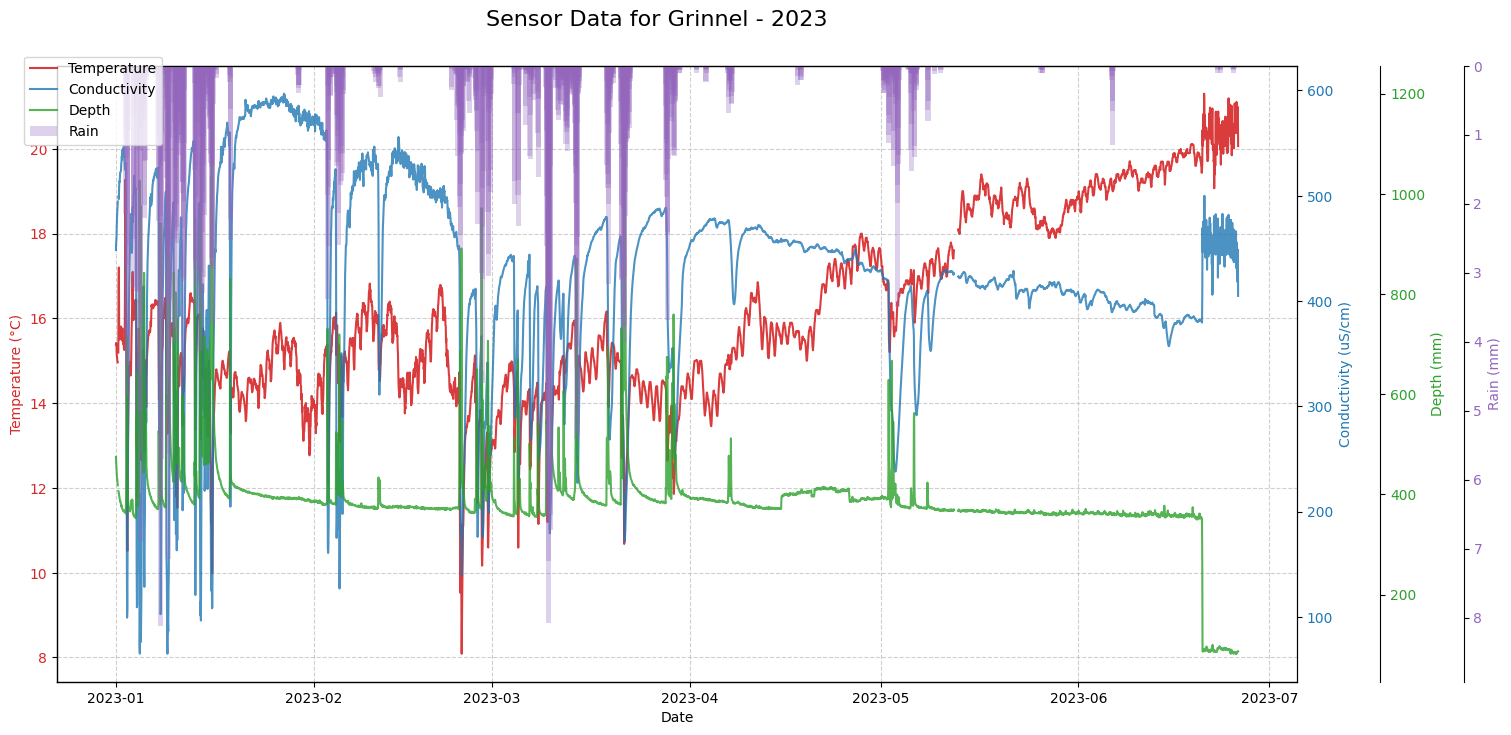

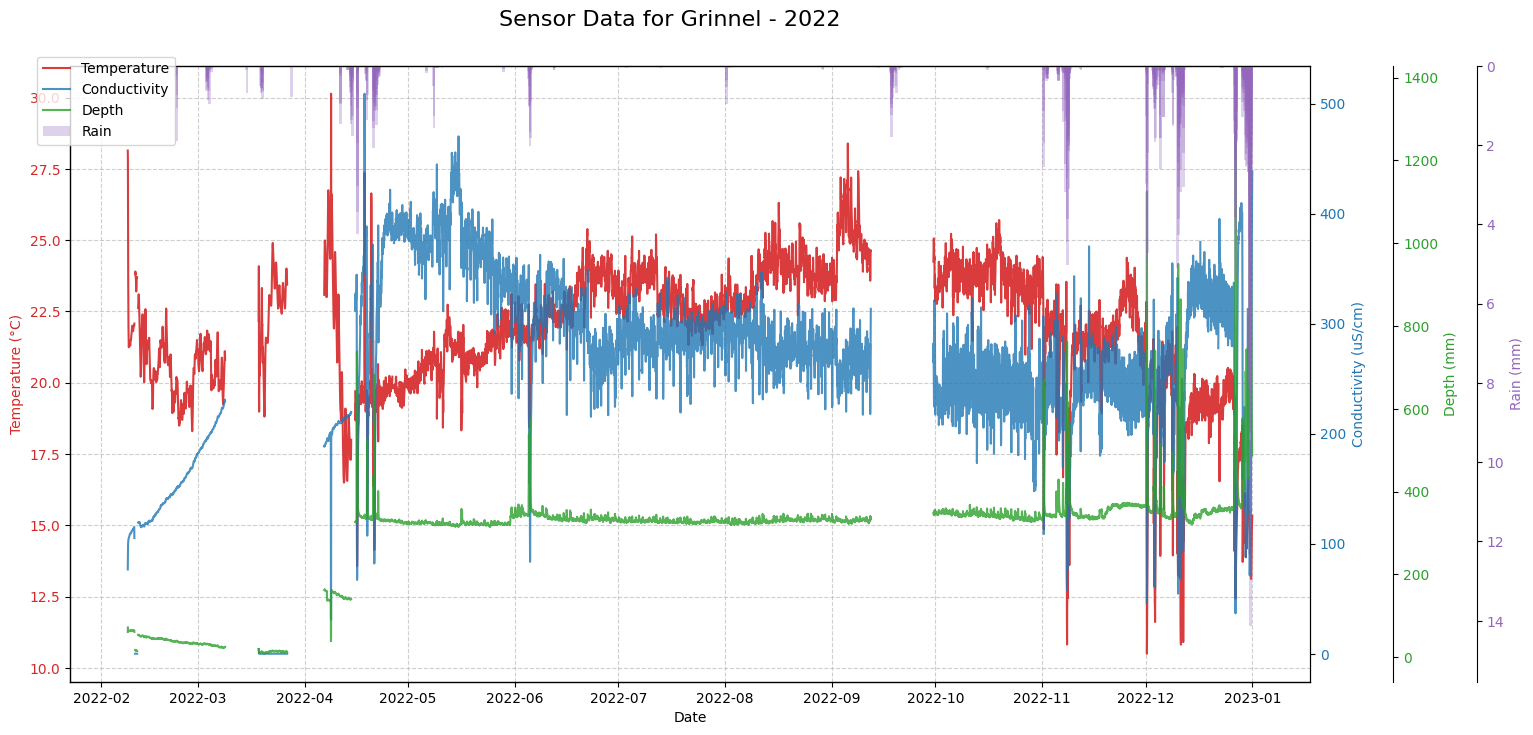

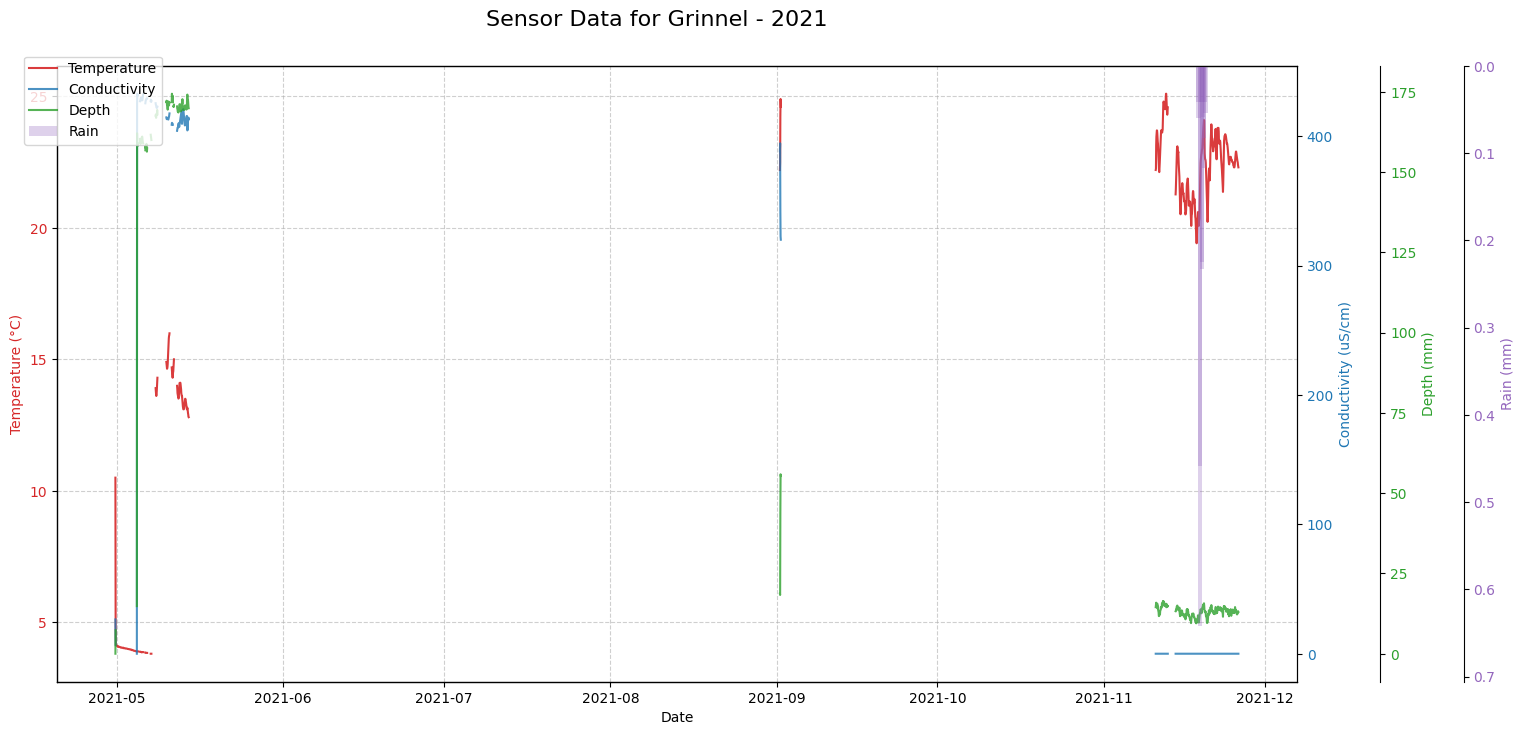

In [96]:
# Plot Grinnel data for 2023, averaged over 24 hours
plot_sensor_data(final_df, location='grinnel', year=2023, hours_avg=1)
# Plot Grinnel data for 2023, averaged over 24 hours
plot_sensor_data(final_df, location='grinnel', year=2022, hours_avg=1)# Plot Grinnel data for 2023, averaged over 24 hours
plot_sensor_data(final_df, location='grinnel', year=2021, hours_avg=1)


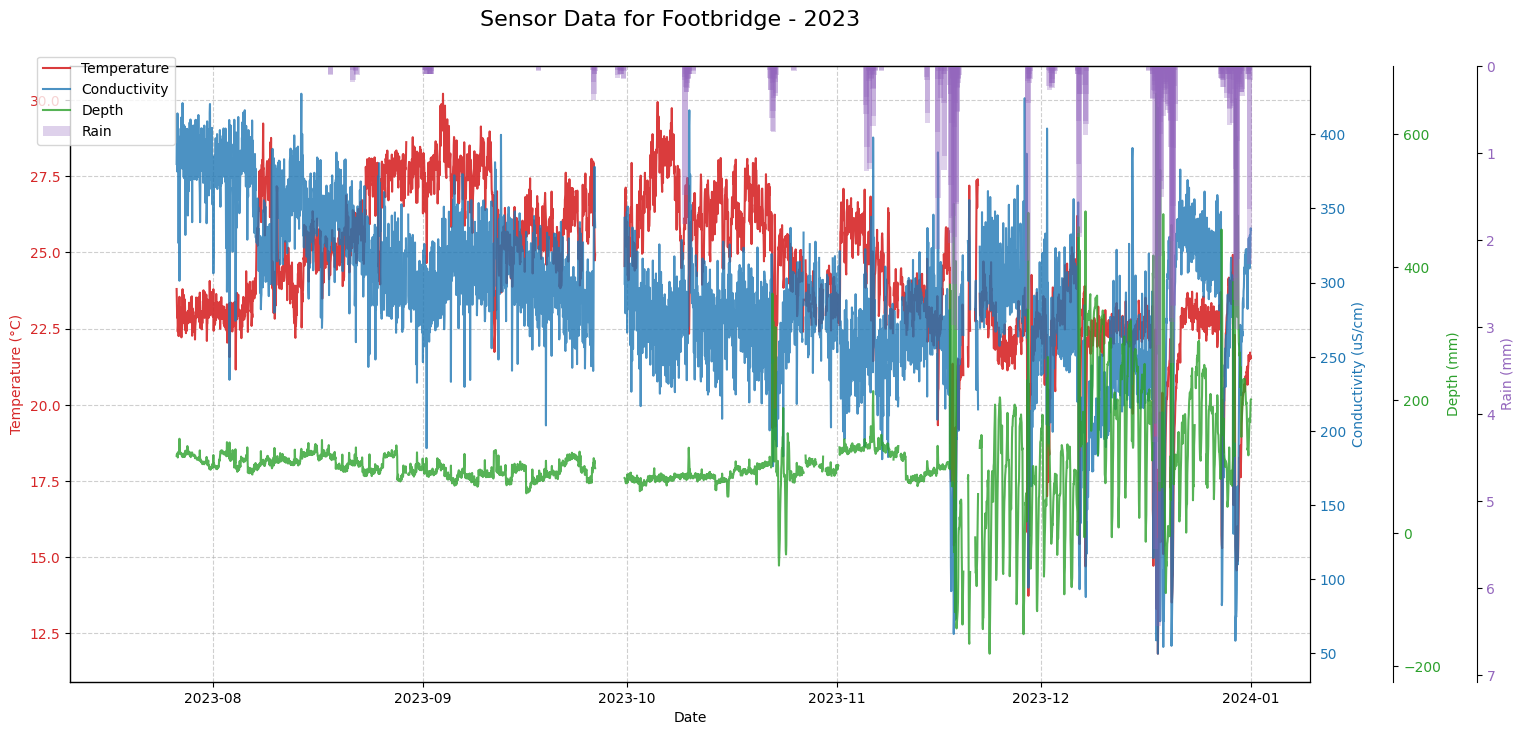

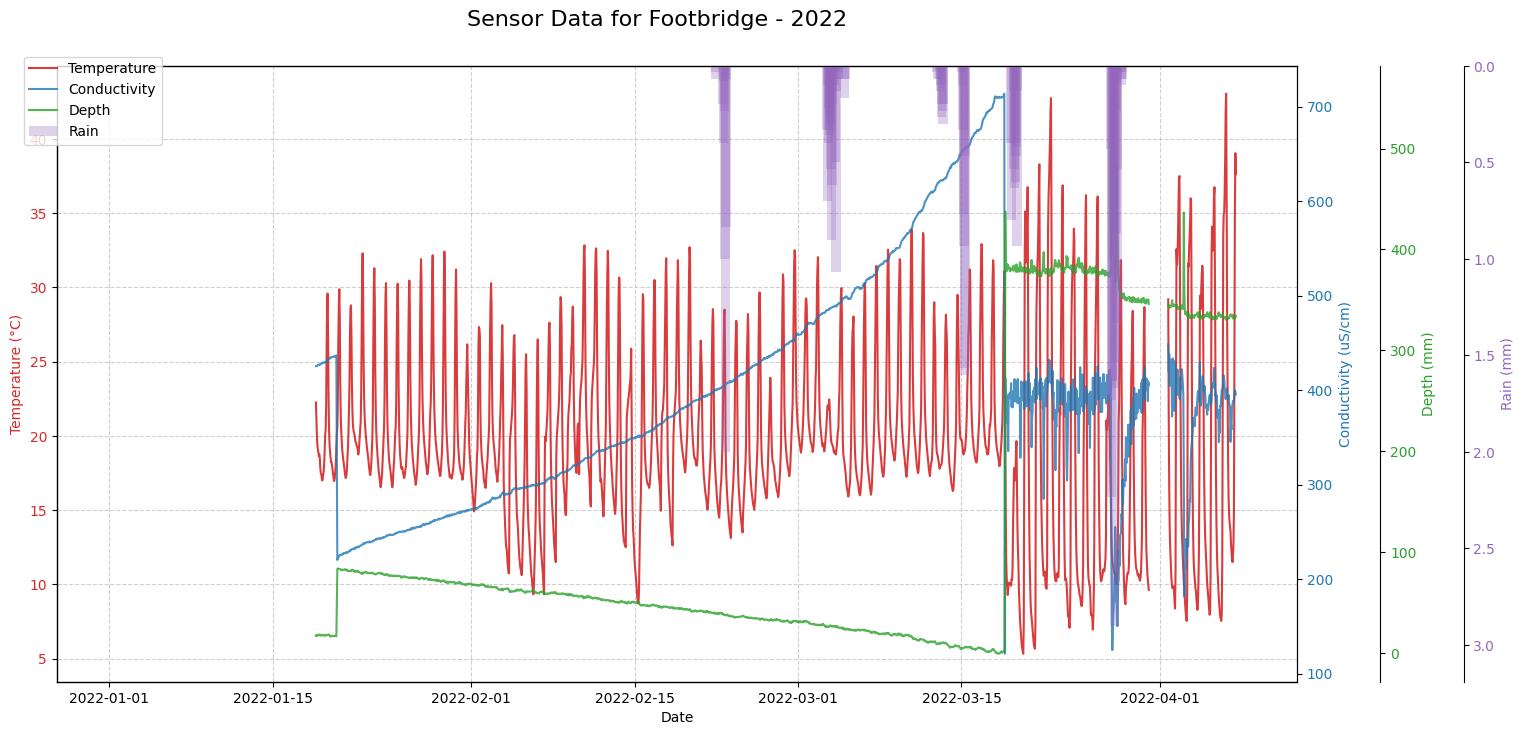

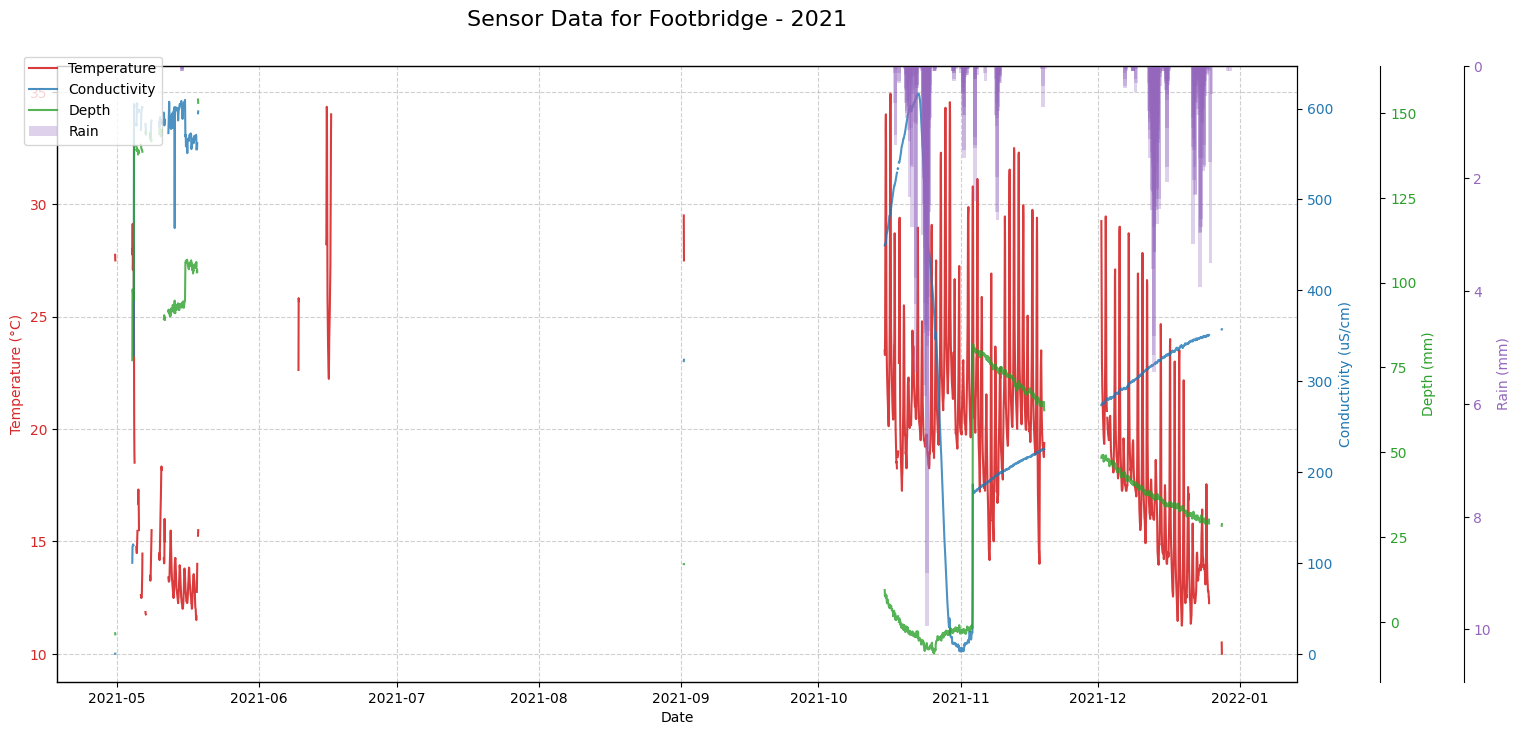

In [97]:
plot_sensor_data(final_df, location='footbridge', year=2023, hours_avg=1)
plot_sensor_data(final_df, location='footbridge', year=2022, hours_avg=1)
plot_sensor_data(final_df, location='footbridge', year=2021, hours_avg=1)


# plot around spill time

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

def plot_date_range(df, location, center_date, window_days=30, hours_avg=None):
    """
    Plots clean sensor and rain data for a specific location around a center date,
    and highlights the center date with a shaded window.
    """
    # --- 1. Filter the data for the specific location and date range ---
    center_ts = pd.to_datetime(center_date)
    start_date = center_ts - pd.Timedelta(days=window_days)
    end_date = center_ts + pd.Timedelta(days=window_days)
    
    plot_df = df[
        (df['location'] == location) &
        (df['datetime'] >= start_date) &
        (df['datetime'] <= end_date)
    ].copy()

    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return

    plot_df = plot_df.set_index('datetime').sort_index()

    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)

    # --- 2. Create the multi-axis plot ---
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)

    # Plot temperature
    ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
    ax_temp.tick_params(axis='y', labelcolor='tab:red')
    if 'temperature' in plot_df.columns:
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)

    # Plot conductivity
    ax_cond = ax_temp.twinx()
    ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
    ax_cond.tick_params(axis='y', labelcolor='tab:blue')
    if 'conductivity' in plot_df.columns:
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)

    # Plot depth
    ax_depth = ax_temp.twinx()
    ax_depth.spines['right'].set_position(('outward', 60))
    ax_depth.set_ylabel('Depth (mm)', color='tab:green')
    ax_depth.tick_params(axis='y', labelcolor='tab:green')
    if 'depth' in plot_df.columns:
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)

    # Plot rain
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)

    # --- NEW: Highlight the Spill Date with a shaded window ---
    span_end = center_ts + pd.Timedelta(days=1)
    ax_temp.axvspan(center_ts, span_end, color='magenta', alpha=0.2, label='Spill Date')

    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

# ===================================================================
#  HOW TO USE IT
# ===================================================================

# Assume 'final_df' is your final, clean, and merged DataFrame.
# The function call is exactly the same as before.



# merge rain data with sensor data from strawberrycreek.org

In [107]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt

# ===================================================================
#  1. API & DATA FETCHING FUNCTIONS
# ===================================================================

def fetch_all_creek_data():
    """Loops through all sites, fetches all available data, and combines it."""
    BASE_URL = "https://www.strawberrycreek.org/api/creek-data/"
    TOKEN = 
    SITES = [
        {"table": "north_fork_0", "label": "North Fork 0"},
        {"table": "scnf010", "label": "North Fork 1 (Wickson Footbridge)"},
        {"table": "south_fork_0", "label": "South Fork 0"},
        {"table": "south_fork_1", "label": "South Fork 1"},
        {"table": "south_fork_2", "label": "South Fork 2"},
        {"table": "south_fork_3", "label": "South Fork 3"},
        {"table": "university_house", "label": "University House"},
        {"table": "oxford", "label": "Oxford Street"},
        {"table": "codornices", "label": "Codornices Creek"}
    ]
    VARIABLES = ["Meter_Hydros21_Cond", "Meter_Hydros21_Depth", "Meter_Hydros21_Temp", "EnviroDIY_Mayfly_Batt"]
    
    all_dataframes = []
    start_date = "2023-01-01"
    end_date = datetime.now().strftime('%Y-%m-%d')
    vars_string = ",".join(VARIABLES)
    headers = {"Authorization": f"Token {TOKEN}"}

    print("Starting data fetch for all sites...")
    for site in SITES:
        params = {'site': site["table"], 'start': start_date, 'end': end_date, 'vars': vars_string}
        try:
            print(f"Fetching data for: {site['label']}...")
            response = requests.get(BASE_URL, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            if data:
                df = pd.DataFrame(data)
                # --- THIS IS THE FIX: Changed 'site' to 'location' ---
                df['location'] = site["table"]
                all_dataframes.append(df)
                print(f"-> Success! Found {len(df)} rows.")
        except requests.exceptions.RequestException as e:
            print(f"-> Failed for {site['label']}. Error: {e}")

    if not all_dataframes:
        print("\nNo data was fetched.")
        return None

    final_df = pd.concat(all_dataframes, ignore_index=True)
    return final_df

def get_openmeteo_rain(lat, lon, start, end):
    """Fetches hourly precipitation for a given location and date range."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {"latitude": lat, "longitude": lon, "start_date": start, "end_date": end, "hourly": "precipitation", "timezone": "auto"}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    df = pd.DataFrame({"datetime": pd.to_datetime(data["hourly"]["time"]), "rain_mm": data["hourly"]["precipitation"]})
    return df

# ===================================================================
#  2. PLOTTING FUNCTION
# ===================================================================

def plot_date_range(df, location, center_date, window_days=30, hours_avg=None):
    """Plots clean sensor and rain data for a specific location around a center date."""
    center_ts = pd.to_datetime(center_date)
    start_date = center_ts - pd.Timedelta(days=window_days)
    end_date = center_ts + pd.Timedelta(days=window_days)
    
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()

    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return

    plot_df = plot_df.set_index('datetime').sort_index()

    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)

    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)

    # Plot Temperature
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)

    # Plot Conductivity
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)

    # Plot Depth
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
    
    # Plot Rain
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)

    # Highlight the "Spill Date" window
    span_end = center_ts + pd.Timedelta(days=1)
    ax_temp.axvspan(center_ts, span_end, color='magenta', alpha=0.2, label='Spill Date')

    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()


# ===================================================================
#  3. MAIN WORKFLOW
# ===================================================================
if __name__ == "__main__":
    # Step 1: Fetch all creek sensor data
    creek_data = fetch_all_creek_data()

    if creek_data is not None:
        # Step 2: Clean and prepare the merged creek data
        print("\nCleaning and preparing data...")
        creek_data.rename(columns={
            'DateTimeUTC': 'datetime',
            'Meter_Hydros21_Temp': 'temperature',
            'Meter_Hydros21_Depth': 'depth',
            'Meter_Hydros21_Cond': 'conductivity',
            'EnviroDIY_Mayfly_Batt': 'battery'
        }, inplace=True)
        creek_data['datetime'] = pd.to_datetime(creek_data['datetime'])
        creek_data.replace(-9999.0, np.nan, inplace=True)

        # Step 3: Fetch rain data for the full date range
        min_year = creek_data['datetime'].min().year
        max_year = creek_data['datetime'].max().year
        today = datetime.now().date()
        
        print(f"Fetching rain data from {min_year} to {max_year}... 🌦️")
        all_rain_list = []
        for year in range(min_year, max_year + 1):
            start_date, end_date = f"{year}-01-01", f"{year}-12-31"
            if year == today.year:
                end_date = today.strftime('%Y-%m-%d')
            # Using a central Berkeley lat/lon for all rain data
            rain_year_df = get_openmeteo_rain(37.87, -122.27, start_date, end_date)
            all_rain_list.append(rain_year_df)
        rain_df = pd.concat(all_rain_list, ignore_index=True)

        # Step 4: Merge creek data with rain data
        print("Merging all data... 🔗")
        creek_data = creek_data.sort_values('datetime')
        rain_df = rain_df.sort_values('datetime')
        final_df = pd.merge_asof(creek_data, rain_df, on='datetime', direction='nearest')

        print("\n--- Final Combined DataFrame ---")
        final_df.info()

        # Step 5: Use the plotting code!
        print("\n--- Generating Example Plots ---")
        # Example 1: Plot the "Wickson Footbridge" site with a 24-hour average


Starting data fetch for all sites...
Fetching data for: North Fork 0...
-> Success! Found 21132 rows.
Fetching data for: North Fork 1 (Wickson Footbridge)...
-> Success! Found 245016 rows.
Fetching data for: South Fork 0...
-> Success! Found 2238 rows.
Fetching data for: South Fork 1...
-> Success! Found 5270 rows.
Fetching data for: South Fork 2...
-> Success! Found 5270 rows.
Fetching data for: South Fork 3...
-> Success! Found 2224 rows.
Fetching data for: University House...
-> Success! Found 6845 rows.
Fetching data for: Oxford Street...
-> Success! Found 7625 rows.
Fetching data for: Codornices Creek...
-> Success! Found 7625 rows.

Cleaning and preparing data...
Fetching rain data from 2023 to 2025... 🌦️


C:\Users\andre\AppData\Local\Temp\ipykernel_30004\397585092.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(all_dataframes, ignore_index=True)


Merging all data... 🔗

--- Final Combined DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303245 entries, 0 to 303244
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      303245 non-null  datetime64[ns]
 1   conductivity  300744 non-null  float64       
 2   depth         300097 non-null  float64       
 3   temperature   300885 non-null  float64       
 4   battery       281061 non-null  float64       
 5   location      303245 non-null  object        
 6   rain_mm       303063 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 16.2+ MB

--- Generating Example Plots ---


# Spill 1 6/6/2023 2420 RIDGE RD



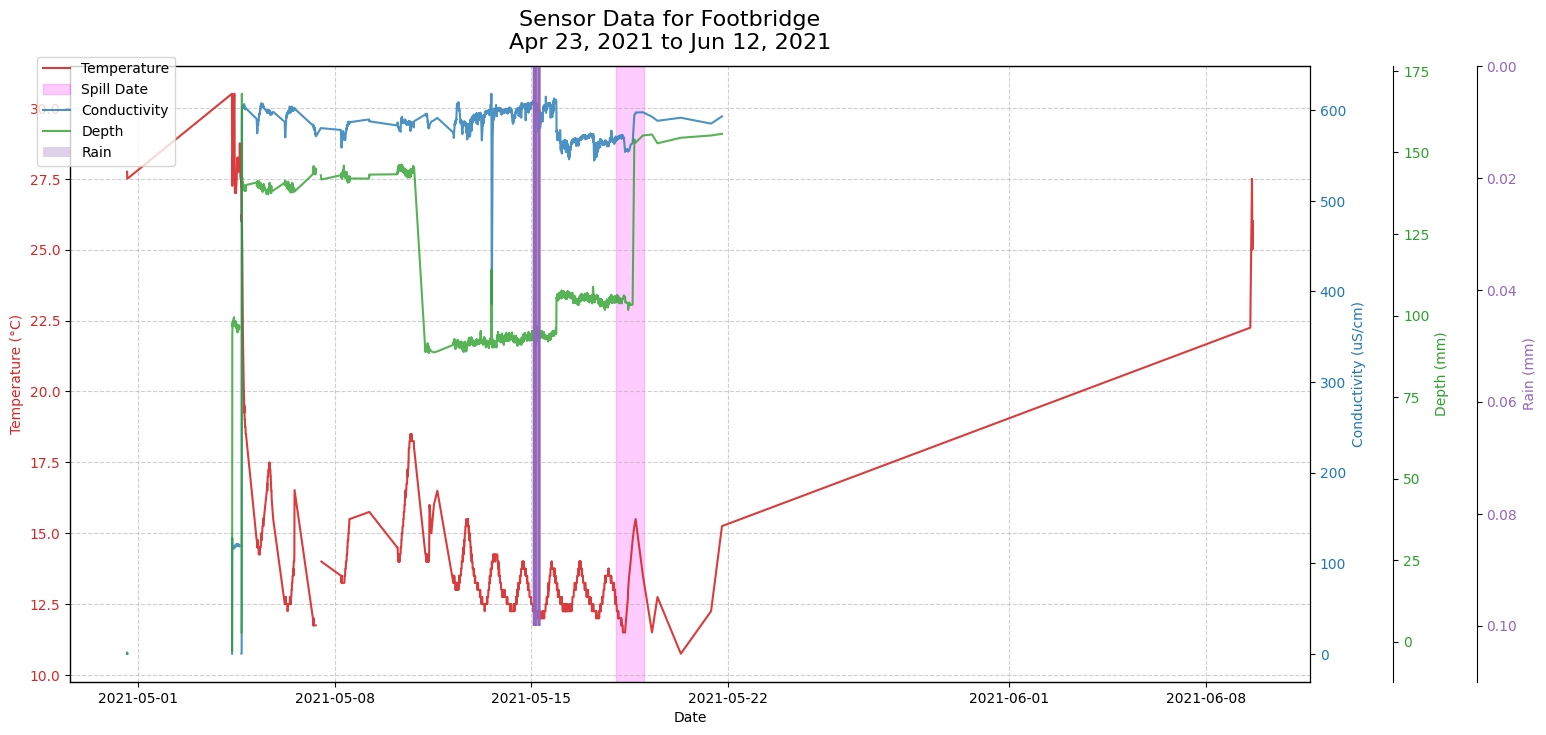

In [106]:
plot_date_range(final_df, location='footbridge', center_date='2021-05-18', window_days=25)


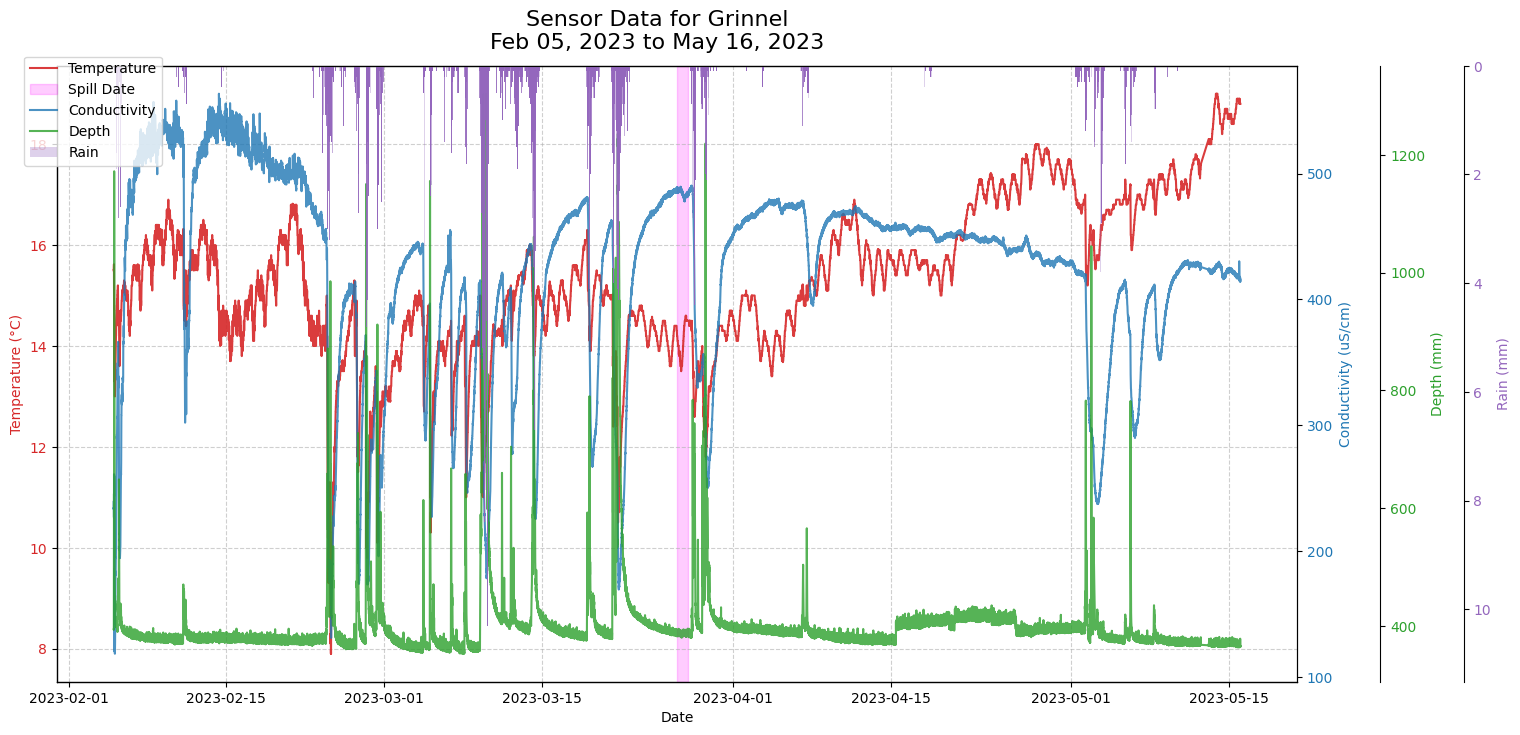

In [100]:
plot_date_range(final_df, location='grinnel', center_date='2023-03-27', window_days=50)

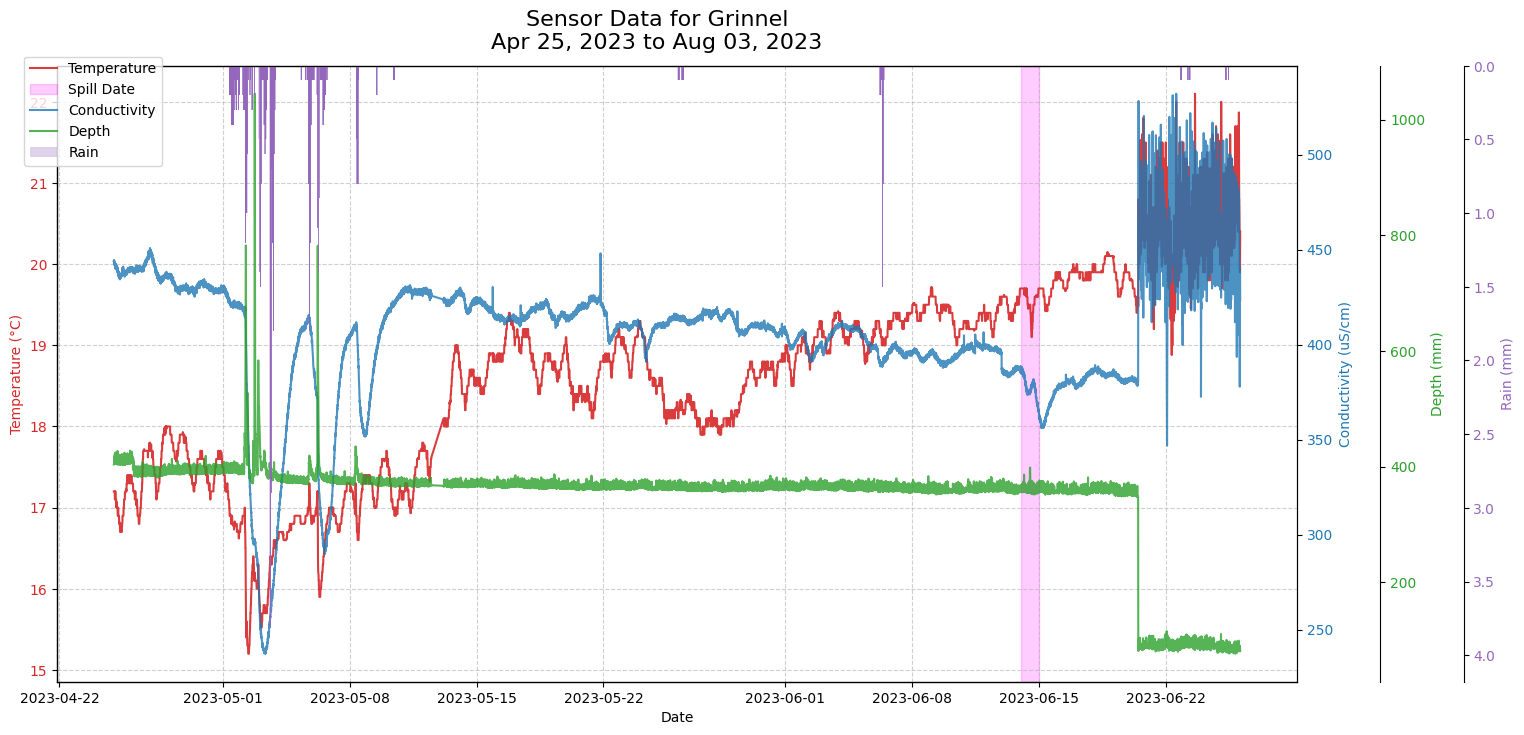

In [101]:
plot_date_range(final_df, location='grinnel', center_date='2023-06-14', window_days=50)

# First spill on South Fork Sensors 

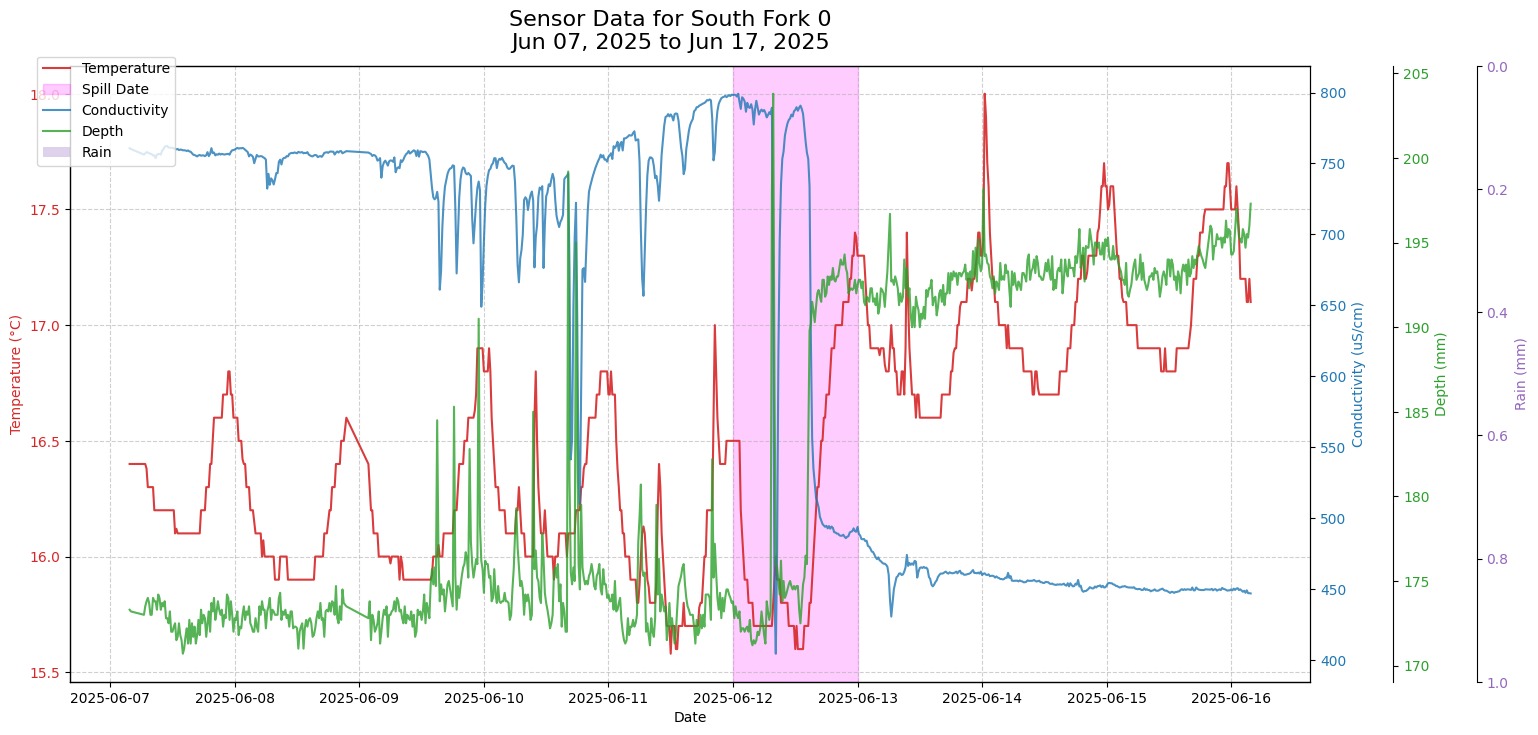

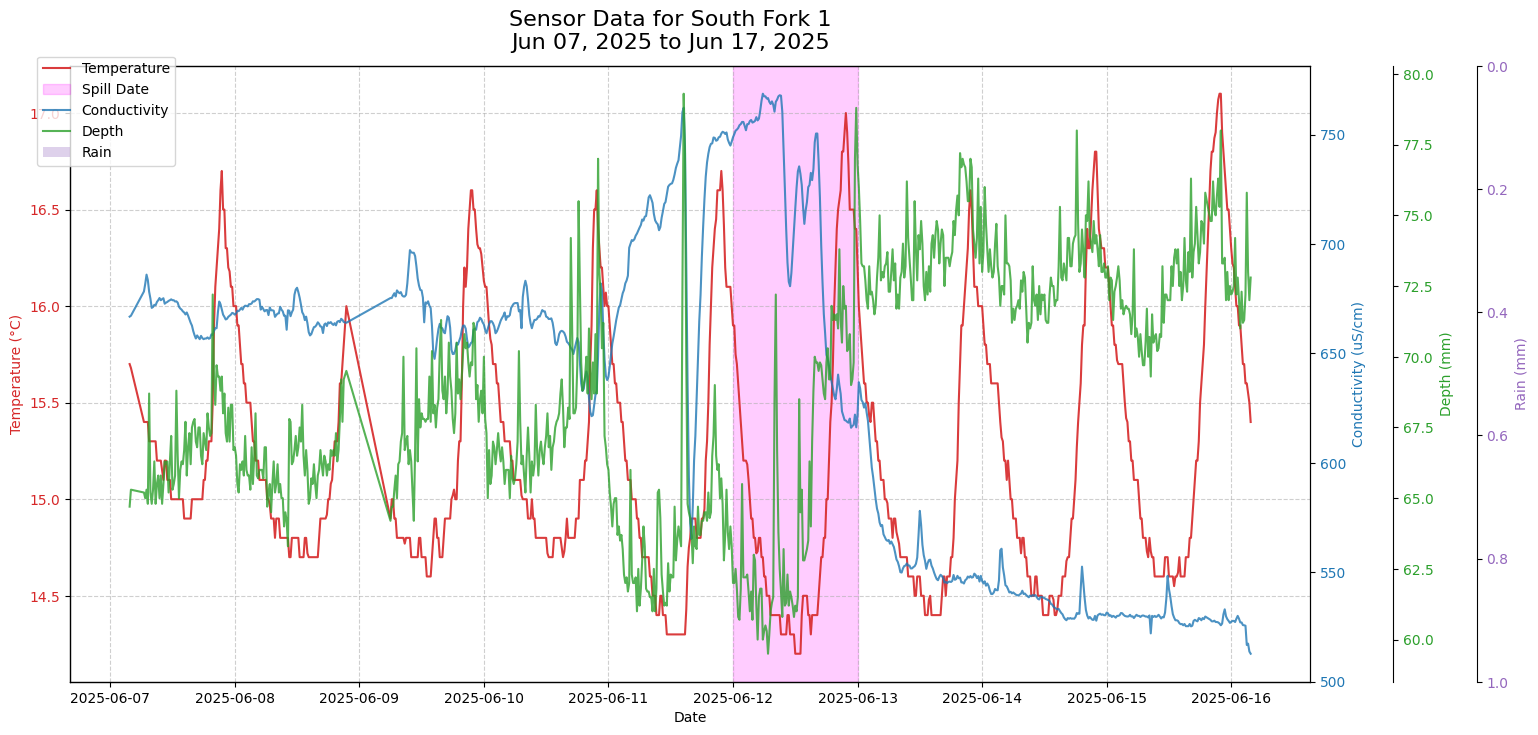

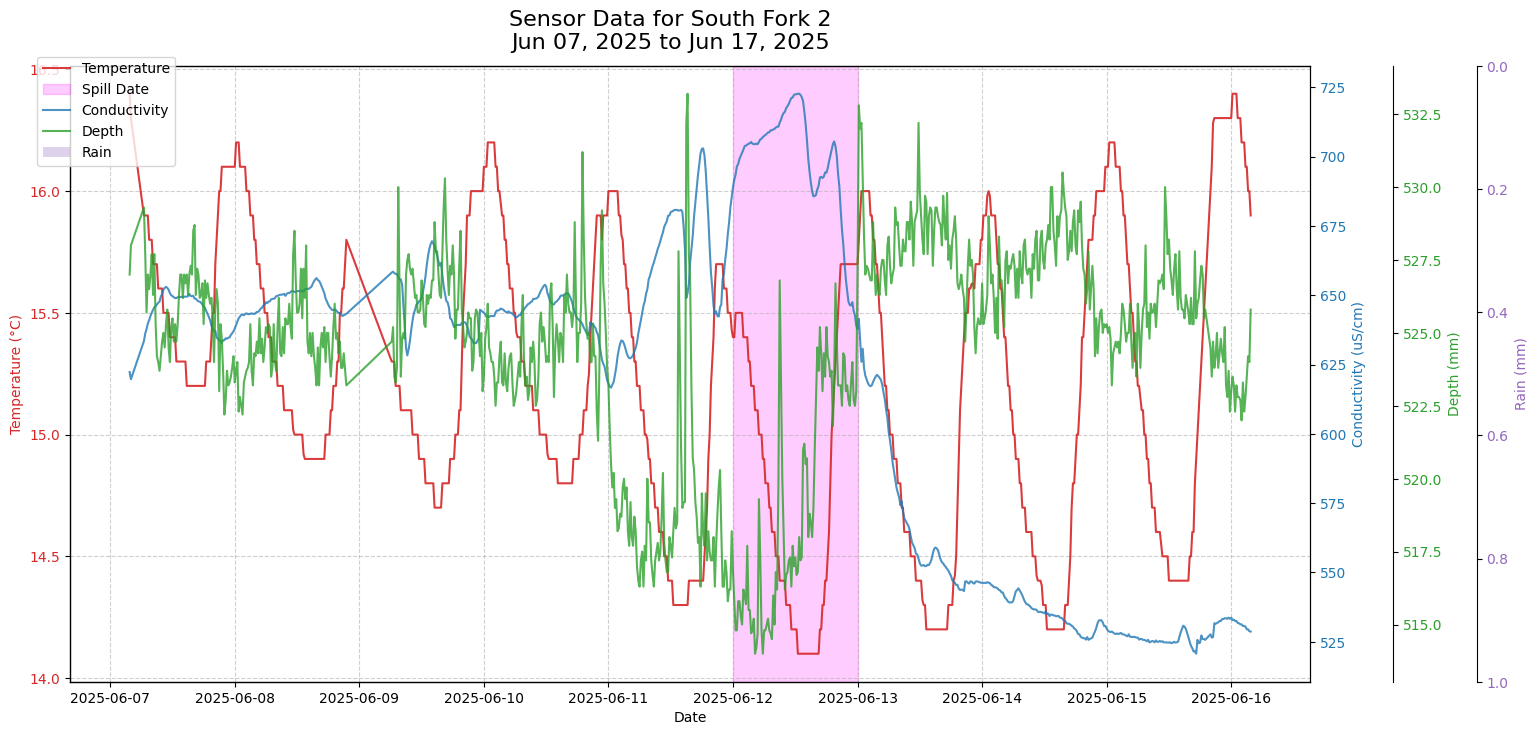

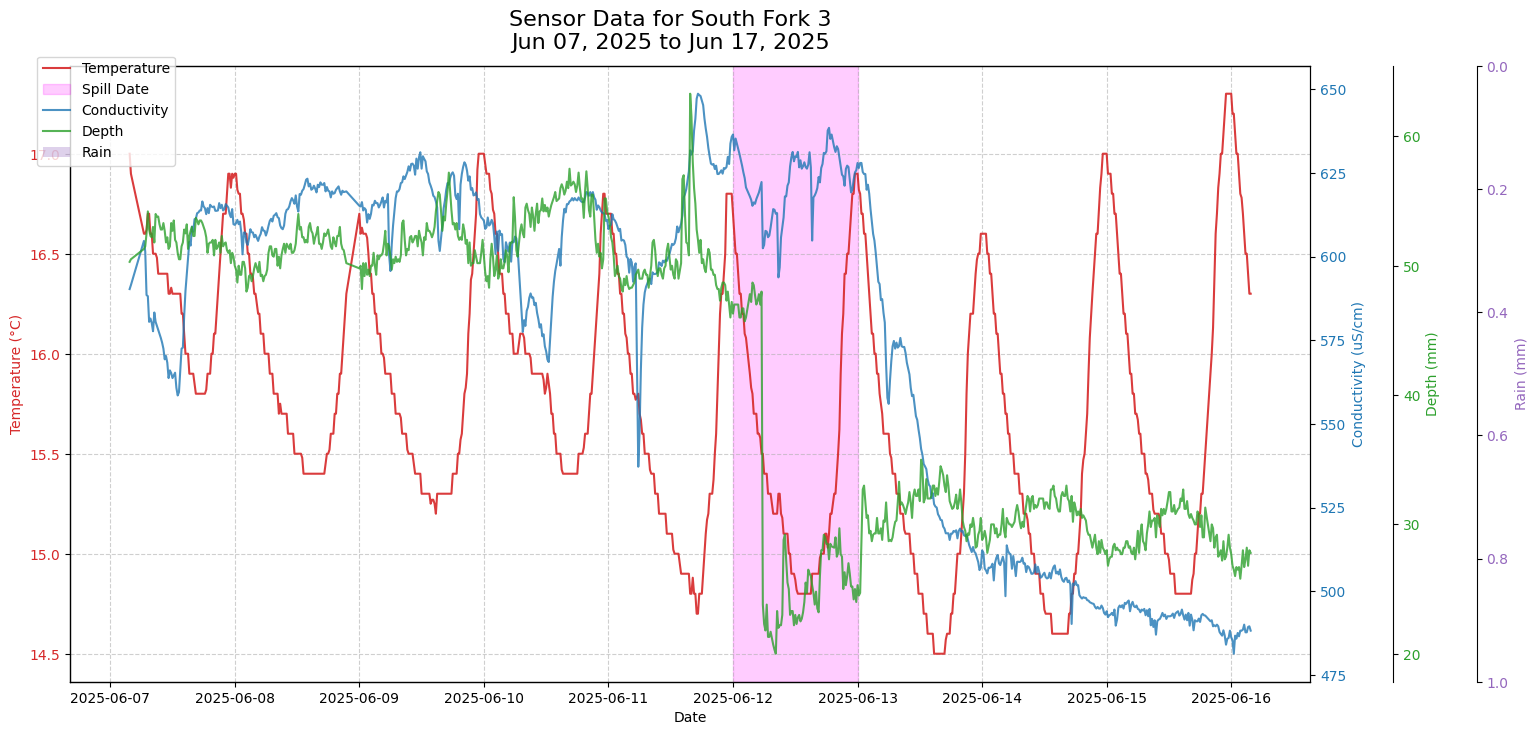

In [79]:
        plot_date_range(
            df=final_df,
            location='south_fork_0', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=5
        )
        
        plot_date_range(
            df=final_df,
            location='south_fork_1', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=5
        )
        plot_date_range(
            df=final_df,
            location='south_fork_2', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=5
        )

        plot_date_range(
            df=final_df,
            location='south_fork_3', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=5
        )


        

# Finding Normal Training data around spill time

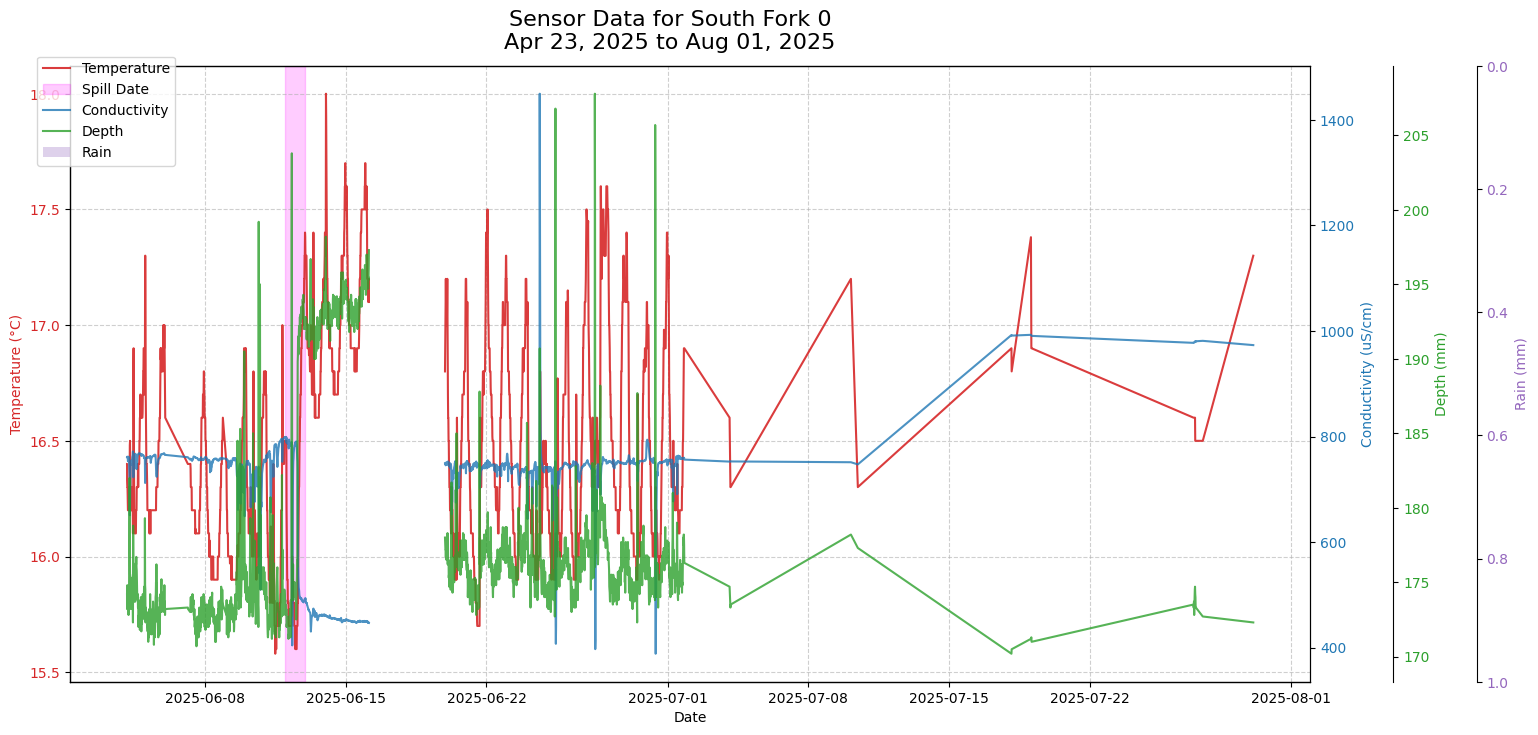

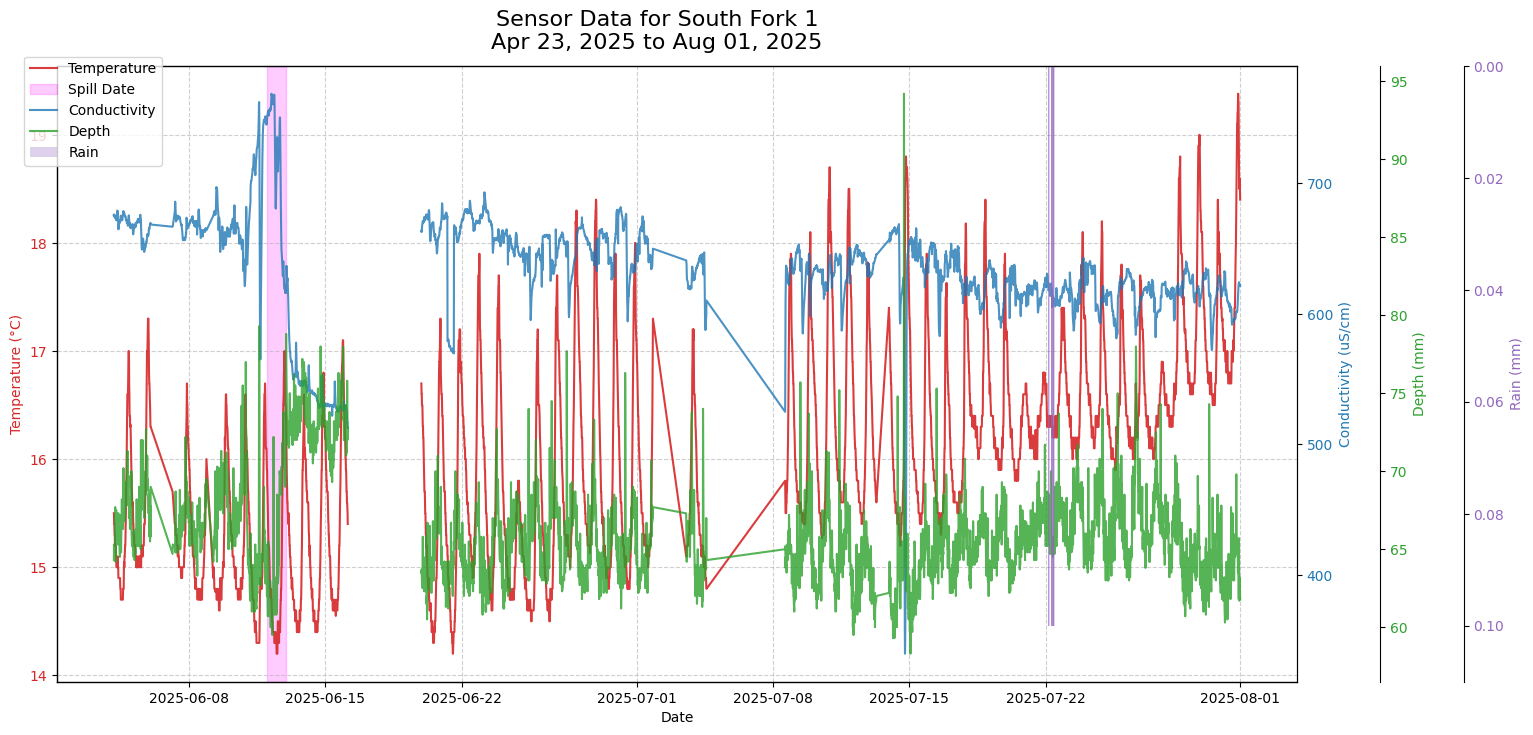

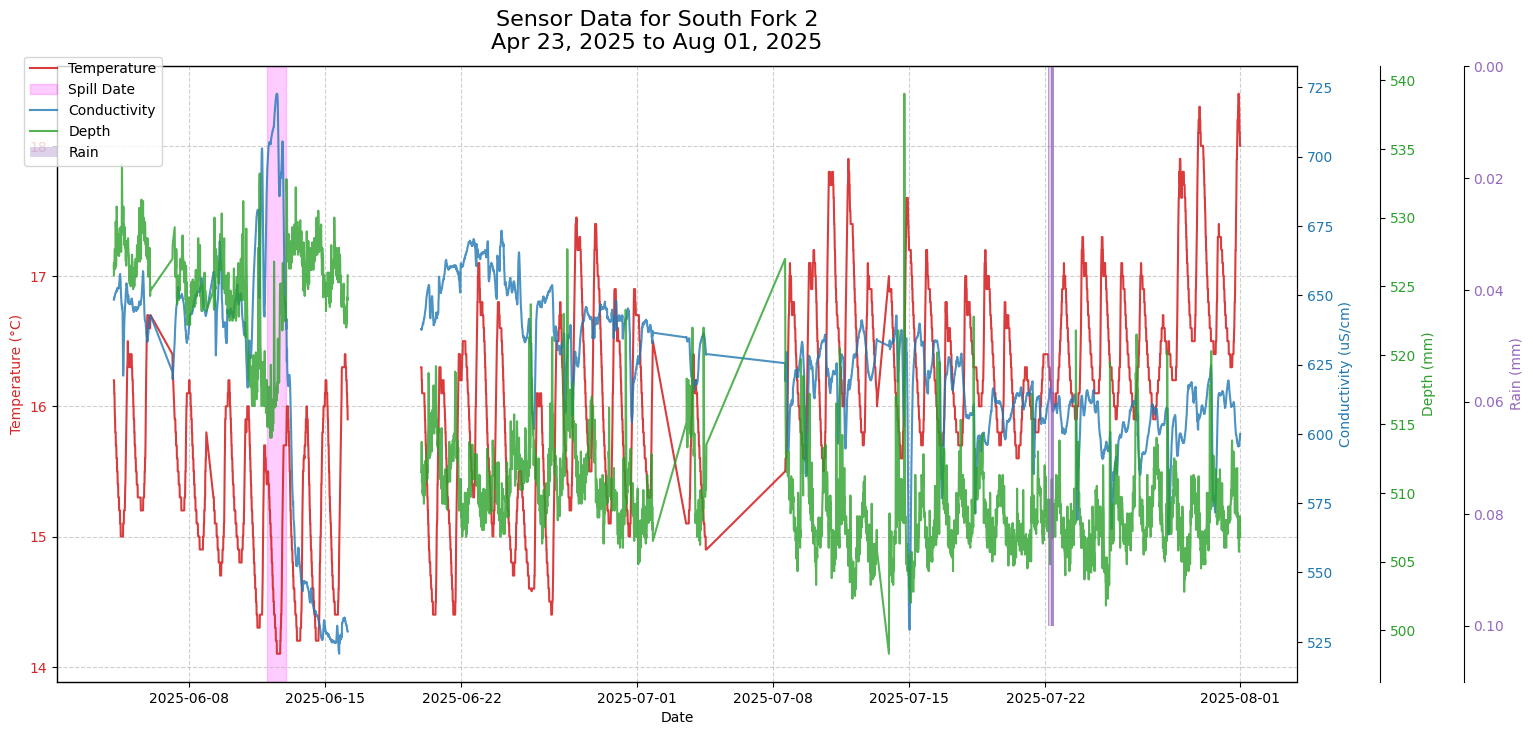

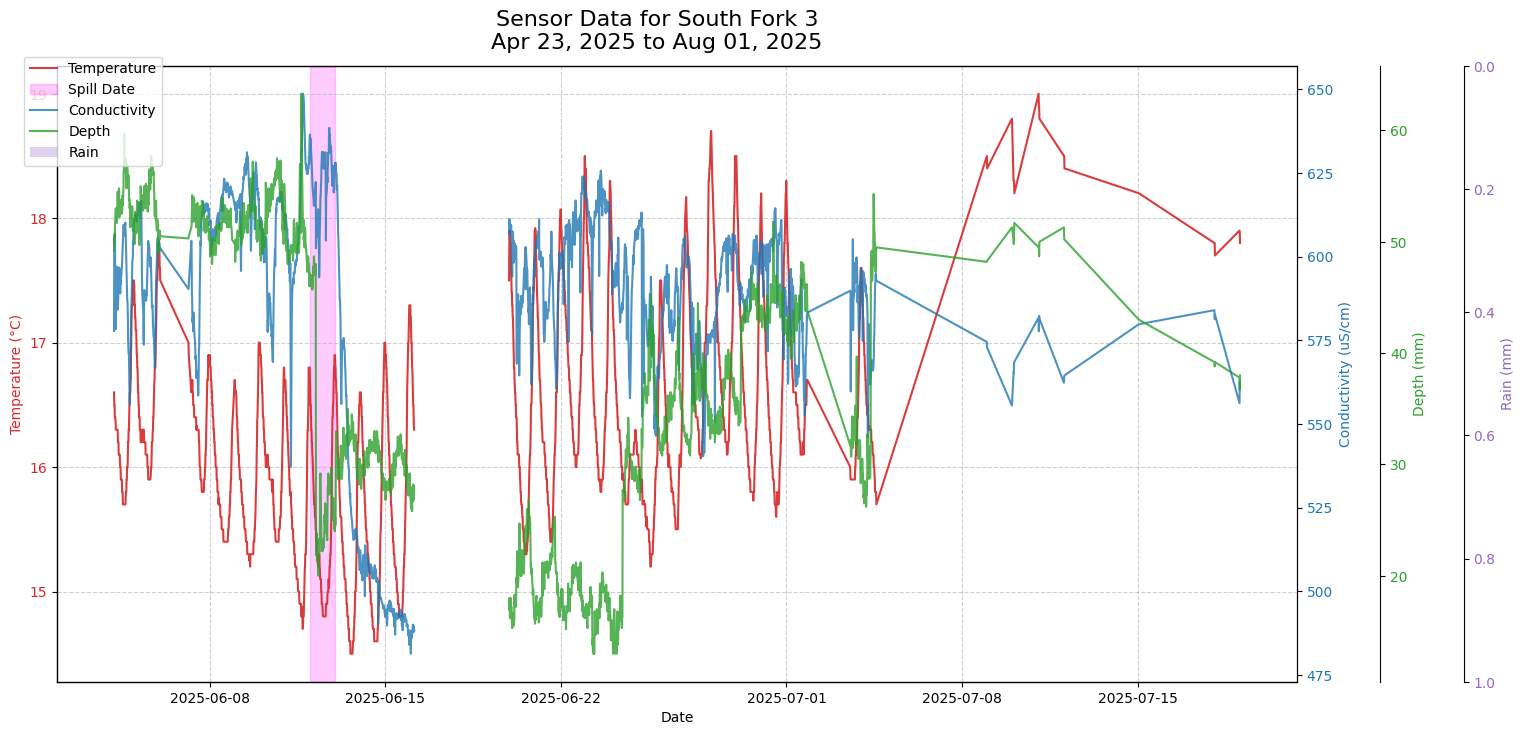

In [80]:
        plot_date_range(
            df=final_df,
            location='south_fork_0', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=50
        )
        
        plot_date_range(
            df=final_df,
            location='south_fork_1', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=50
        )
        plot_date_range(
            df=final_df,
            location='south_fork_2', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=50
        )

        plot_date_range(
            df=final_df,
            location='south_fork_3', # This is the table name for Wickson Footbridge
            center_date='2025-06-12',
            window_days=50
        )


        